In [2]:
import time
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = torchvision.transforms.Compose(
                [torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,),(0.3081,))])

train_dataset = torchvision.datasets.MNIST('data', train=True,
                                           download=True,
                                           transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False,
                                          download=True,
                                          transform=transform)

batch_size_train, batch_size_test = 64, 1000

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test,
                                          shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 896977.51it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 64712.28it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1248180.34it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5082851.86it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [27]:
def train(model: nn.Module,
          loss_fn: nn.modules.loss._Loss,
          optimizer: torch.optim.Optimizer,
          train_loader: torch.utils.data.DataLoader,
          epoch: int=0)-> List:
    model.train()
    train_loss = []

    for batch_idx, (images, targets) in enumerate(train_loader):
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

        if batch_idx % 100 == 0:
          print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.3f}')

    return train_loss

def test(model: nn.Module,
         loss_fn: nn.modules.loss._Loss,
         test_loader: torch.utils.data.DataLoader,
         epoch: int=0)-> Dict:
    model.eval()
    test_stat = {}
    test_loss = 0
    correct = 0
    pred_arr = torch.tensor([]).to(device)

    with torch.no_grad():
      for images, targets in test_loader:
        images, targets = images.to(device), targets.to(device)
        output = model(images)
        test_loss += loss_fn(output, targets).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(targets.data.view_as(pred)).sum()
        pred_arr = torch.cat((pred_arr, pred.view(-1).to(device)))

    test_loss /= len(test_loader)
    test_stat['accuracy'] = correct / len(test_loader.dataset)
    test_stat['loss'] = test_loss
    test_stat['prediction'] = pred_arr

    print(f"Test result on epoch {epoch}: total sample: {len(test_loader)}, Avg loss: {test_stat['loss']:.3f}, Acc: {100*test_stat['accuracy']:.3f}%")

    return test_stat

In [5]:
# def compute_kl_loss(p, q, pad_mask=None):
#     p_loss = F.kl_div(F.log_softmax(p, dim=-1), F.softmax(q, dim=-1), reduction='batchmean')
#     q_loss = F.kl_div(F.log_softmax(q, dim=-1), F.softmax(p, dim=-1), reduction='batchmean')
#     loss = (p_loss + q_loss) / 2
#     return loss

def compute_kl_loss(p, q, pad_mask=None):
    eps = 1e-8
    p = F.log_softmax(p, dim=-1)
    q = F.softmax(q, dim=-1)
    q = torch.clamp(q, min=eps)
    p_loss = F.kl_div(p, q, reduction='batchmean')
    q_loss = F.kl_div(F.log_softmax(q, dim=-1), F.softmax(p, dim=-1), reduction='batchmean')
    loss = (p_loss + q_loss) / 2
    return loss

def rdrop_loss(output1, output2, target, alpha=1.0):
    ce_loss = 0.5 * (F.cross_entropy(output1, target) + F.cross_entropy(output2, target))
    kl_loss = compute_kl_loss(output1, output2)
    loss = ce_loss + alpha * kl_loss
    return loss

def train_with_RDrop(model: nn.Module,
          loss_fn: nn.modules.loss._Loss,
          optimizer: torch.optim.Optimizer,
          train_loader: torch.utils.data.DataLoader,
          epoch: int=0,
          alpha: int=1)-> List:
    model.train()
    train_loss = []

    for batch_idx, (images, targets) in enumerate(train_loader):
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        output1 = model(images)
        output2 = model(images)
        loss = loss_fn(output1, output2, targets, alpha)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if torch.isnan(loss).any():
          print("NaN loss detected, stopping training.")
          break

        train_loss.append(loss.item())

        if batch_idx % 100 == 0:
          print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.3f}')

    return train_loss

In [14]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    self.conv = nn.Conv2d(1, 3, kernel_size=5)
    self.dropout = nn.Dropout(0.5)
    self.fc = nn.Linear(432, 10)

  def forward(self, x):
    x = self.conv(x)
    x = F.relu(F.max_pool2d(x,2))
    x = self.dropout(x)
    x = x.view(-1, 432)
    x = F.relu(self.fc(x))
    return F.log_softmax(x,-1)

In [26]:
# # WITHOUT DROPOUT
# start = time.time()

# model = SimpleCNN()
# model = model.to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
# epochs = 2

# for epoch in range(1, epochs):
#   train(model, F.cross_entropy, optimizer, train_loader, epoch)
#   test(model, F.cross_entropy, test_loader, epoch)

# end = time.time()
# print(f'Finished Training after {end-start} s ')

Epoch 1: [0/60000] Loss: 2.333
Epoch 1: [6400/60000] Loss: 0.520
Epoch 1: [12800/60000] Loss: 0.449
Epoch 1: [19200/60000] Loss: 0.499
Epoch 1: [25600/60000] Loss: 0.373
Epoch 1: [32000/60000] Loss: 0.289
Epoch 1: [38400/60000] Loss: 0.310
Epoch 1: [44800/60000] Loss: 0.276
Epoch 1: [51200/60000] Loss: 0.144
Epoch 1: [57600/60000] Loss: 0.201
tensor(944, device='cuda:0')
tensor(1882, device='cuda:0')
tensor(2827, device='cuda:0')
tensor(3765, device='cuda:0')
tensor(4705, device='cuda:0')
tensor(5677, device='cuda:0')
tensor(6645, device='cuda:0')
tensor(7634, device='cuda:0')
tensor(8621, device='cuda:0')
tensor(9574, device='cuda:0')
Test result on epoch 1: total sample: 10, Avg loss: 0.160, Acc: 95.740%
Finished Training after 15.498905181884766 s 


In [8]:
# # WITH DROPOUT
# start = time.time()

# model = SimpleCNN()
# model = model.to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
# epochs = 2

# for epoch in range(1, epochs):
#   train_with_RDrop(model, rdrop_loss, optimizer, train_loader, epoch, 1)
#   test(model, F.cross_entropy, test_loader, epoch)

# end = time.time()
# print(f'Finished Training after {end-start} s ')

In [28]:
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=-1)

Epoch 1: [0/60000] Loss: 2.302
Epoch 1: [6400/60000] Loss: 2.291
Epoch 1: [12800/60000] Loss: 2.157
Epoch 1: [19200/60000] Loss: 1.422
Epoch 1: [25600/60000] Loss: 0.682
Epoch 1: [32000/60000] Loss: 0.551
Epoch 1: [38400/60000] Loss: 0.280
Epoch 1: [44800/60000] Loss: 0.474
Epoch 1: [51200/60000] Loss: 0.577
Epoch 1: [57600/60000] Loss: 0.654
Test result on epoch 1: total sample: 10, Avg loss: 0.111, Acc: 96.510%
Epoch 2: [0/60000] Loss: 0.293
Epoch 2: [6400/60000] Loss: 0.249
Epoch 2: [12800/60000] Loss: 0.338
Epoch 2: [19200/60000] Loss: 0.231
Epoch 2: [25600/60000] Loss: 0.211
Epoch 2: [32000/60000] Loss: 0.175
Epoch 2: [38400/60000] Loss: 0.102
Epoch 2: [44800/60000] Loss: 0.179
Epoch 2: [51200/60000] Loss: 0.113
Epoch 2: [57600/60000] Loss: 0.041
Test result on epoch 2: total sample: 10, Avg loss: 0.097, Acc: 97.140%
Epoch 3: [0/60000] Loss: 0.136
Epoch 3: [6400/60000] Loss: 0.216
Epoch 3: [12800/60000] Loss: 0.301
Epoch 3: [19200/60000] Loss: 0.105
Epoch 3: [25600/60000] Loss: 0.

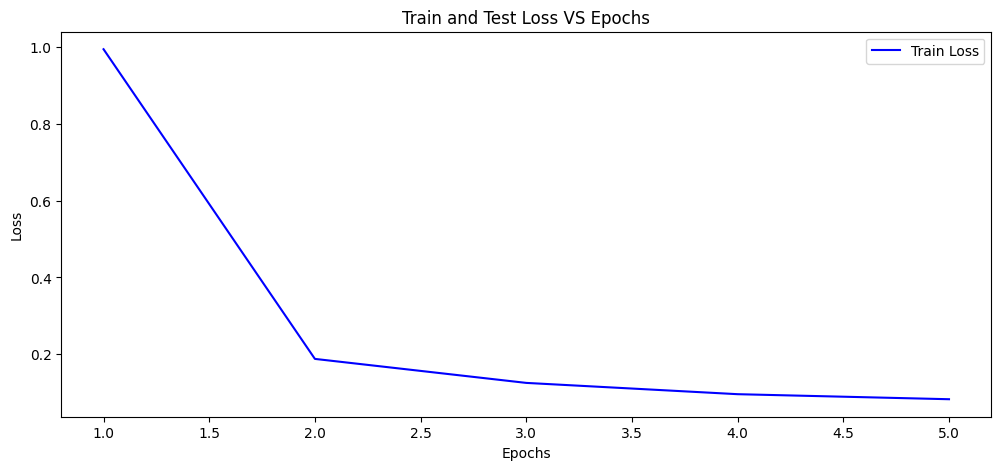

In [31]:
# WITHOUT DROPOUT

start = time.time()
model = DeeperCNN()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
epochs = 5

avg_train_losses = []
test_losses = []

for epoch in range(1, epochs + 1):
  train_loss = train(model, F.cross_entropy, optimizer, train_loader, epoch)
  test_stat = test(model, F.cross_entropy, test_loader, epoch)

  avg_train_loss = sum(train_loss) / len(train_loss)
  avg_train_losses.append(avg_train_loss)
  test_losses.append(test_stat['loss'])

end = time.time()
print(f'Finished Training after {end-start} s ')


# Plotting the losses
plt.figure(figsize=(12,5))
plt.plot(range(1, epochs + 1), avg_train_losses, label='Train Loss', color='blue')
# plt.scatter(range(1, epochs + 1), test_losses, label='Test Loss', color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss VS Epochs')
plt.legend()
plt.show()

Epoch 1: [0/60000] Loss: 2.324
Epoch 1: [6400/60000] Loss: 2.253
Epoch 1: [12800/60000] Loss: 1.990
Epoch 1: [19200/60000] Loss: 1.608
Epoch 1: [25600/60000] Loss: 1.493
Epoch 1: [32000/60000] Loss: 1.444
Epoch 1: [38400/60000] Loss: 1.305
Epoch 1: [44800/60000] Loss: 1.287
Epoch 1: [51200/60000] Loss: 1.387
Epoch 1: [57600/60000] Loss: 1.306
Test result on epoch 1: total sample: 10, Avg loss: 0.423, Acc: 92.370%
Epoch 2: [0/60000] Loss: 1.313
Epoch 2: [6400/60000] Loss: 1.052
Epoch 2: [12800/60000] Loss: 1.090
Epoch 2: [19200/60000] Loss: 1.134
Epoch 2: [25600/60000] Loss: 1.297
Epoch 2: [32000/60000] Loss: 1.172
Epoch 2: [38400/60000] Loss: 1.106
Epoch 2: [44800/60000] Loss: 1.102
Epoch 2: [51200/60000] Loss: 1.134
Epoch 2: [57600/60000] Loss: 0.972
Test result on epoch 2: total sample: 10, Avg loss: 0.192, Acc: 95.990%
Epoch 3: [0/60000] Loss: 0.987
Epoch 3: [6400/60000] Loss: 0.967
Epoch 3: [12800/60000] Loss: 0.991
Epoch 3: [19200/60000] Loss: 1.411
Epoch 3: [25600/60000] Loss: 1.

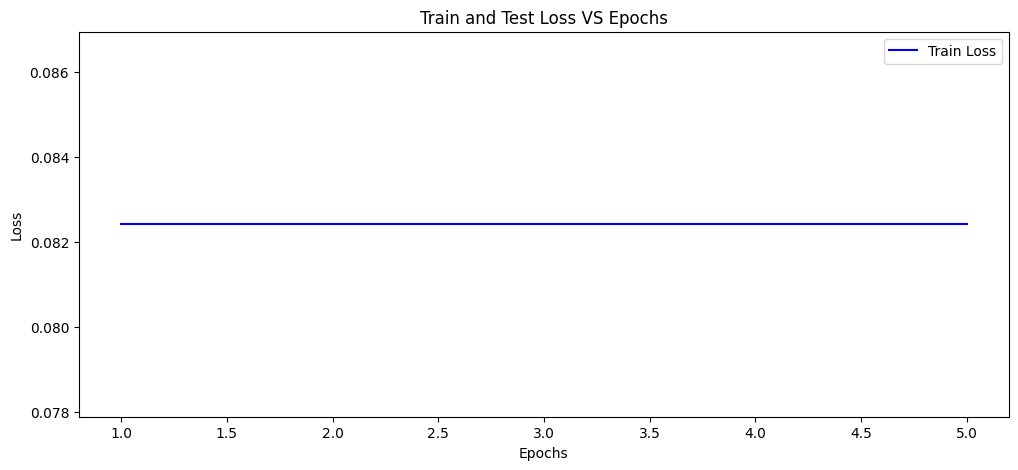

In [32]:
# WITH DROPOUT
start = time.time()
model = DeeperCNN()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
epochs = 5

avg_train_losses = []
test_losses = []

for epoch in range(1, epochs + 1):
  train_with_RDrop(model, rdrop_loss, optimizer, train_loader, epoch, 1)
  test(model, F.cross_entropy, test_loader, epoch)

  avg_train_loss = sum(train_loss) / len(train_loss)
  avg_train_losses.append(avg_train_loss)
  test_losses.append(test_stat['loss'])

end = time.time()
print(f'Finished Training after {end-start} s ')

# Plotting the losses
plt.figure(figsize=(12,5))
plt.plot(range(1, epochs + 1), avg_train_losses, label='Train Loss', color='blue')
# plt.scatter(range(1, epochs + 1), test_losses, label='Test Loss', color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss VS Epochs')
plt.legend()
plt.show()